# 1 - introduction, talk about the dataset, why we chose it and any cleaning/transformation that was applied to it.

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import modularity
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
import random

In [ ]:
filename = 'lichess_db_standard_rated_2016-04_game_info.csv'

games_df = pd.read_csv(filename, usecols=[6, 7, 15, 16, 13, 14, 17, 18], engine='c')
print(f'original: {games_df.shape[0]}')
games_df = games_df[games_df.winner != 'draw']

games_df['loser_elo'] = pd.to_numeric(games_df['loser_elo'], errors='coerce')
games_df['winner_elo'] = pd.to_numeric(games_df['winner_elo'], errors='coerce')


original: 5922667


In [ ]:
# Create nodes_df
winners = pd.DataFrame({
    'player': games_df['winner'],
    'title': np.where(games_df['winner'] == games_df['white'], games_df['white_title'], games_df['black_title']),
    'elo': games_df['winner_elo']
})
losers = pd.DataFrame({
    'player': games_df['loser'],
    'title': np.where(games_df['loser'] == games_df['white'], games_df['white_title'], games_df['black_title']),
    'elo': games_df['loser_elo']
})
# join winners and losers, remove dups
nodes_df = pd.concat([winners, losers]).drop_duplicates(subset=['player'], keep='first')

# create edges_df, sum wins by winner-loser group
edges_df = games_df[['winner', 'loser']].copy()
edges_df['wins'] = 1
edges_df = edges_df.groupby(['winner', 'loser'], as_index=False).sum()

In [ ]:
nodes_df2 = nodes_df.copy()
nodes_df2.title = np.where(nodes_df2.title.isnull(), 0, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'CM', 1, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'LM', 2, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'NM', 3, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'IM', 4, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'FM', 5, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'WFM', 6, nodes_df2.title)
nodes_df2.title = np.where(nodes_df2.title == 'GM', 7, nodes_df2.title)

In [ ]:
# create directed graph from edgesdf
gamesG = nx.from_pandas_edgelist(edges_df, source='winner', target='loser', edge_attr=True, create_using=nx.DiGraph())
node_attr = nodes_df.set_index('player').to_dict('index') # honestly i copied it from stackoverflow
nx.set_node_attributes(gamesG, node_attr)                     # assign attributes to nodes

In [ ]:
def node_attributes(node):
    return {'elo': nx.get_node_attributes(gamesG, 'elo').get(node),
            'title': nx.get_node_attributes(gamesG, 'title').get(node)}

In [ ]:
def round_to_nearest_hundred(num):
    return round(num / 100) * 100

In [ ]:
for node in [node for node, elo in nx.get_node_attributes(gamesG, 'elo').items() if elo > nodes_df.elo.quantile(.99)]:
    gamesG.nodes[node]['elogephi'] = round_to_nearest_hundred(gamesG.nodes[node]['elo'])
nodes_1pc = [node for node, elo in nx.get_node_attributes(gamesG, 'elo').items() if elo > nodes_df.elo.quantile(.99)]
subgraph = gamesG.subgraph(nodes_1pc)
#nx.write_gexf(subgraph, "large_graph_with_bins.gexf")

In [ ]:
all_names = pd.concat([edges_df['winner'], edges_df['loser']])      # check how many times each player uniquely
                                                                    # played against some other
name_counts = all_names.value_counts()
name_counts.describe()

count    117150.000000
mean         74.092702
std         128.914589
min           1.000000
25%           4.000000
50%          21.000000
75%          91.000000
max        2648.000000
Name: count, dtype: float64

# Plot functions

In [ ]:
import matplotlib.pyplot as plt

def bar_plot(x, y, title, xlabel, ylabel, size=(10,10), clr='skyblue', edg_color='black'):

    plt.figure(figsize=size)

    plt.bar(x, y, color=clr, edgecolor=edg_color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

def hist_plot(values, title, xlabel, ylabel='Frequency', bars=20, edg_color='black', size=(10,10)):

    plt.figure(figsize=size)

    plt.hist(values, bins=bars, edgecolor=edg_color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

def cdf_plot(values, title, xlabel, ylabel='CDF', grid=True, size=(10,10), mrkr = '.', style ='none'):
    values = sorted(values)

    cdf = np.arange(1, len(values) + 1) / len(values)

    plt.figure(figsize=size)

    plt.plot(values, cdf, marker=mrkr, linestyle=style)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(grid)
    plt.show()

# 2 - Degree distribution, assortativity, graph density, conneted components

Degree Distribution

2649


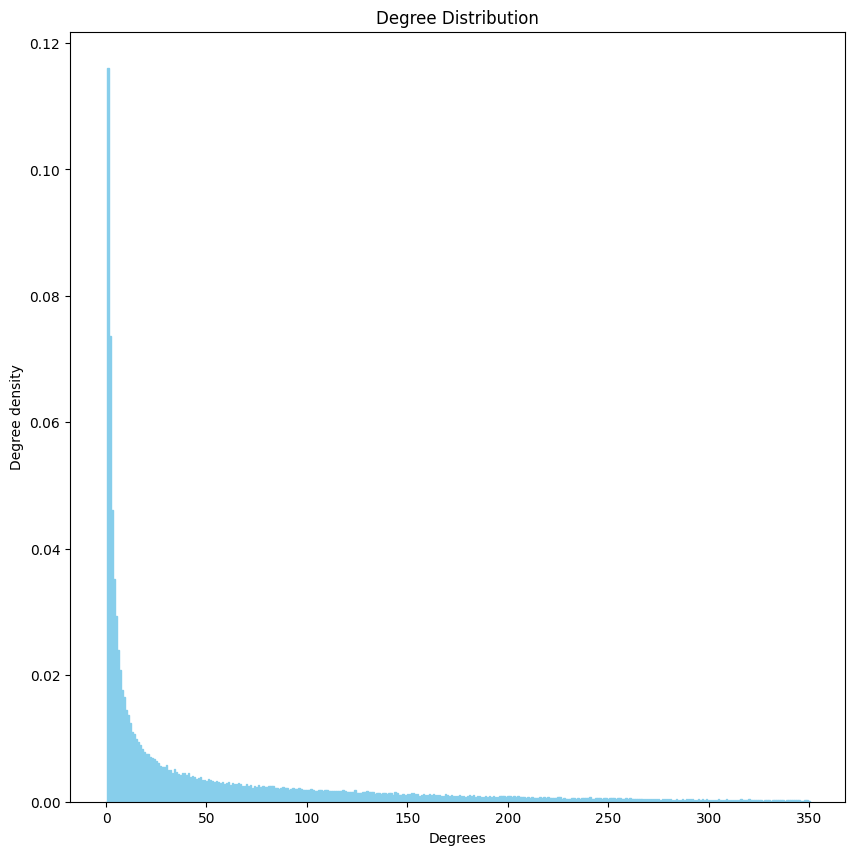

In [ ]:
from matplotlib.pyplot import bar

degrees_freq = nx.degree_histogram(gamesG)

num_of_nodes = gamesG.number_of_nodes()

degree_distribution = [i/num_of_nodes for i in degrees_freq]

degrees = [i for i in range(len(degree_distribution))]

print(len(degree_distribution))

bar_plot(degrees[0:351], degree_distribution[0:351], "Degree Distribution", "Degrees", "Degree density", edg_color='skyblue')

Since, for each node, an edge connects two people who played against each other, looking at this plot we see that almost 12% of players only played against one person and that most players either played for very little time or only play very casually, because as the degrees (amount of people who they played against) go up, the Degree density goes down massively. It's also worth noting that since the edges are directed, with an edge meaning win/wins or loss/losses, each node can have 2 edges connecting it to the same node, which means each player probably played against even less players than their nodes' degree distribution.

Assortativity

Assortativity is a measure of the tendency of nodes in a network to connect to other nodes with similar or dissimilar attributes. It tells us whether nodes with similar characteristics are more likely to be connected to each other.

Assortativity with respect to the node degree

In [ ]:
nx.degree_assortativity_coefficient(gamesG)

0.1619948324596466

Assortativity with respect to elo

In [ ]:
nx.numeric_assortativity_coefficient(gamesG, 'elo')

0.5364192034535864

The numeric assortativity coefficient of 0.54 for the Elo attribute indicates a moderate to strong positive assortativity. This means that players with similar Elo ratings tend to compete against each other more frequently. Higher-rated players are more likely to play against other high-rated players, and similarly, lower-rated players are more likely to face opponents with lower Elo ratings. This reflects a common pattern in competitive systems where players are matched based on skill levels to ensure balanced competition.

Assortativity with respect to title

In [ ]:
nx.attribute_assortativity_coefficient(gamesG, 'title')

0.031017607622676607

Graph Density

The graph density for a directed graph is given by:
$$
\text{Densidade} = \frac{E}{N \times (N - 1)}
$$

It differs from the density for an undirected graph by a factor of 1/2 due to the fact that has the double of possible max links.

In [ ]:
nx.density(gamesG)

0.0003162327534359348

A graph density of 0.000316 indicates that the graph is very sparse, meaning only about 0.0316% of the possible directed edges between players actually exist.

In practical terms, this suggests that while there are many potential interactions (matches) between players in the graph, only a small fraction of those matches have actually occurred. This sparsity is typical in networks where the number of possible connections grows quadratically with the number of nodes, but real-world interactions are limited.

Connected Components

Connected components are subgraphs in which any two nodes are connected by a path

Strongly Connected Components

Components where all nodes in the component have paths to each other in both directions.

In [ ]:
strongly_conn_comps = [c for c in sorted(nx.strongly_connected_components(gamesG), key=len, reverse=True)] # Components in which there is a directed path from any node to any other node inside the same component (the output is the set of nodes from each component)
                                                                                                           # There are singular components, sets comprised of only 1 node, meaning there is no other node connected with paths in both ways to that node
strongly_conn_comps

[{'junkspace',
  'onlybrand',
  'abbas56b',
  'IngeG',
  'Olocofczei16',
  'Dr_3z',
  'tallyone',
  'chess_anarchist',
  'yasssinov',
  'Saint-Nicolas',
  'Ybelskiy',
  'jaume33',
  'zeuslol',
  'williamduque82',
  'lepouldu03',
  'iExodia',
  'gnomechildslayer',
  'Behnaaam',
  'coma1990',
  'gutoledo',
  'SiberianLion',
  'Hyurt',
  'thomasimmanuel',
  'steelydaan',
  'Aladinek',
  'Asshhhhz',
  'Frayz',
  'MiguelOchoaR',
  'RezaMasoumi',
  'Oscar_Hernandez',
  'gfsf_s342f',
  'LLlaxmaTucT59',
  'Calso',
  'bobbyjoe44445',
  'IISupermanII',
  'miggonz13',
  'stjp_80',
  'Panfrio',
  'krooked1488',
  'thedevalex',
  'BassMaster',
  'elnene',
  'VonPlatypus',
  'pastramiking',
  'gaywasme',
  'belmin123',
  'hamed4040',
  'TheLegendaryRaichu',
  'chessko',
  'Dragonpw',
  'risty',
  'stuar',
  'FatihKulaber',
  'Rumo_75',
  'Lukechess',
  'redthunder90',
  'profexadrez',
  'Xekmat',
  'afrocentric',
  'xambis',
  'exiles228',
  'ostapmat',
  'Ivar1',
  'Eugenio1980',
  'SametAltun08',


Weakly Connected Components

Components where, if treated as undirected, all nodes in the component have paths to each other in both directions.

In [ ]:
weakly_conn_comps = [c for c in sorted(nx.weakly_connected_components(gamesG), key=len, reverse=True)] # Components in which if we ignore the directions of the edges there is a path from any node to any other node inside the same component
                                                                                                       # This time there are no singular components because in our dataset every player has played against atleast one other player, which means that the smallest components have 2 nodes
weakly_conn_comps

[{'junkspace',
  'rafa_ga12',
  'onlybrand',
  'DaxLoy',
  'Satrancnetwork',
  'abbas56b',
  'IngeG',
  'Olocofczei16',
  'Dr_3z',
  'tallyone',
  'rocnail23',
  'chess_anarchist',
  'yasssinov',
  'Saint-Nicolas',
  'Ybelskiy',
  'jaume33',
  'anu1918',
  'zeuslol',
  'williamduque82',
  'lepouldu03',
  'iraniancarlsen',
  'igrey_tash',
  'Bazem',
  'iExodia',
  'gnomechildslayer',
  'coma1990',
  'Behnaaam',
  'gutoledo',
  'SiberianLion',
  'ChimerFateful',
  'onehppeace',
  'Hyurt',
  'thomasimmanuel',
  'Psiaczek5',
  'steelydaan',
  'Aladinek',
  'Asshhhhz',
  'caseissexy',
  'RezaMasoumi',
  'MiguelOchoaR',
  'gfsf_s342f',
  'LLlaxmaTucT59',
  'Oscar_Hernandez',
  'Frayz',
  'Calso',
  'JarlFloki',
  'bobbyjoe44445',
  'IISupermanII',
  'miggonz13',
  'stjp_80',
  'Panfrio',
  'krooked1488',
  'elnene',
  'BassMaster',
  'thedevalex',
  'VonPlatypus',
  'pastramiking',
  'TheLegendaryRaichu',
  'belmin123',
  'hamed4040',
  'gaywasme',
  'kiwipoul10',
  'chessko',
  'Dragonpw',


In [ ]:
print(len(strongly_conn_comps))

print(len(weakly_conn_comps))

24237
730


In [ ]:
print(len(strongly_conn_comps[0]))

92374


In [31]:
len(list(strongly_conn_comps[0]))


92374

In [ ]:
strongest_component = list(strongly_conn_comps[0])


In [40]:
strongest_component = set(list(strongly_conn_comps[0]))
filtered_df = nodes_df[nodes_df['player'].isin(strongest_component)]
elo_avg = filtered_df['elo'].mean()

elo_avg

1584.2058696169918

# 3 - Degree centrality, Betweenness centrality, Proximity

Degree Centrality

Degree centrality is a measure of the importance or influence of a node in a graph based on its number of direct connections. In this case measures which players played against more opponents (not necessarily the ones that played more games), and therefore, have more influence.

In-degree Centrality measures the proportion of nodes that have directed edges toward a specific node.
It is calculated as:

$$
\text{In-degree centrality of node } v = \frac{\text{in-degree of } v}{N - 1}
$$


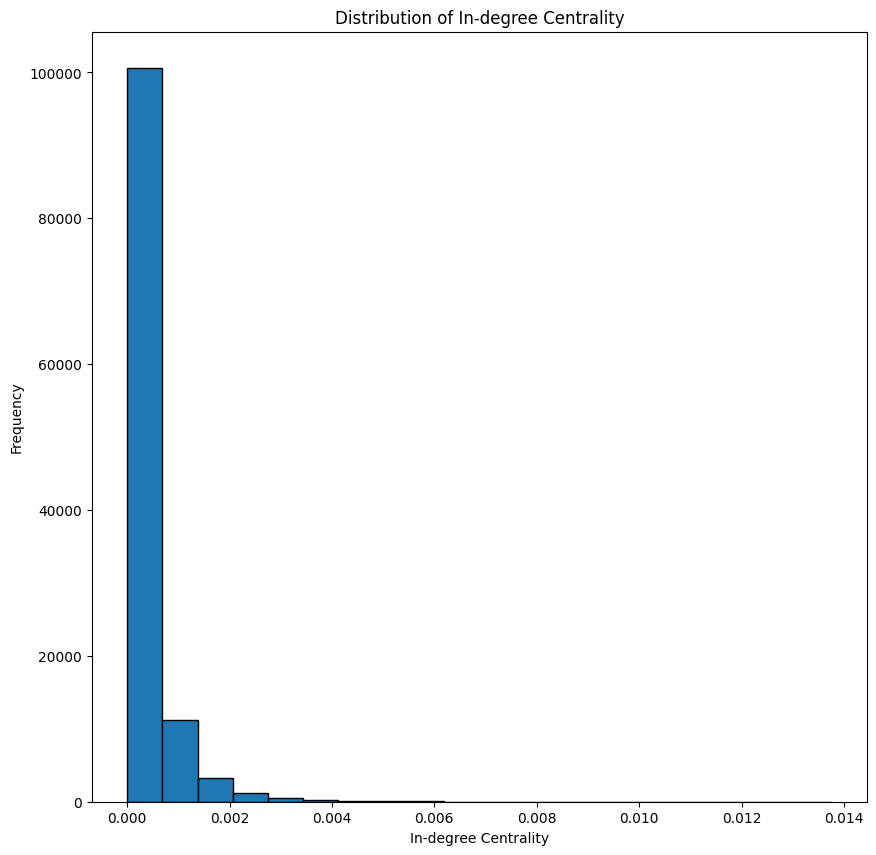

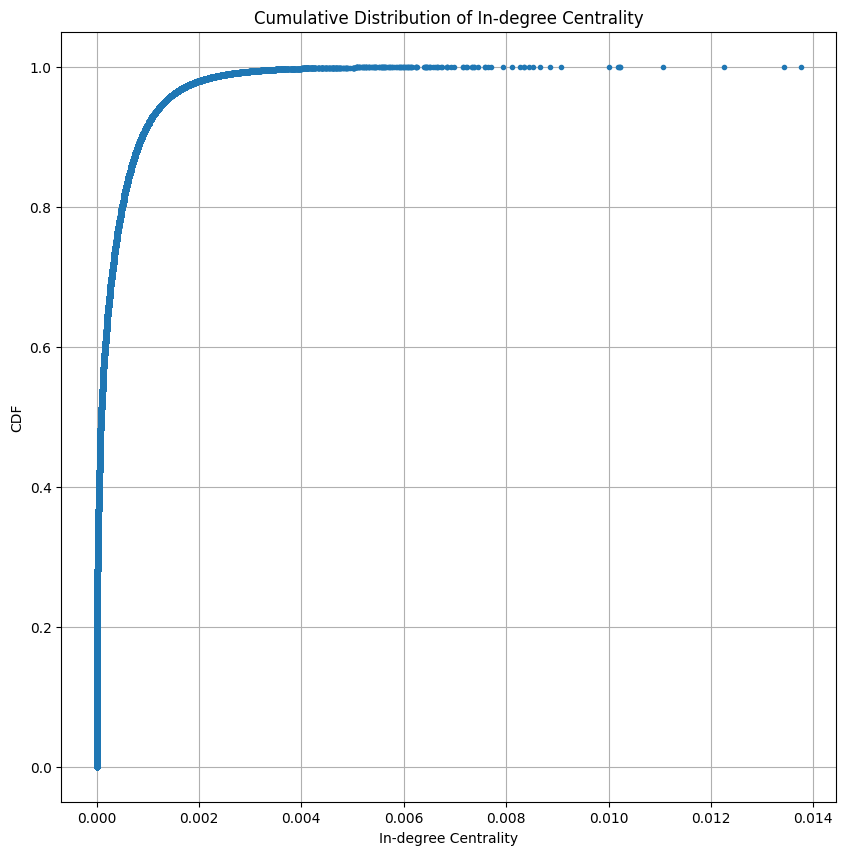

In [21]:
in_deg_cent = dict(sorted(nx.in_degree_centrality(gamesG).items(), key=lambda item: item[1], reverse=True))

values = list(in_deg_cent.values())

hist_plot(values, 'Distribution of In-degree Centrality', 'In-degree Centrality')

cdf_plot(values, 'Cumulative Distribution of In-degree Centrality', 'In-degree Centrality')

Out-degree Centrality measures the proportion of nodes that a specific node has directed edges towards.

Similar to in_degree centrality, we calculate it as:

$$
\text{Out-degree centrality of node } v = \frac{\text{out-degree of } v}{N - 1}
$$


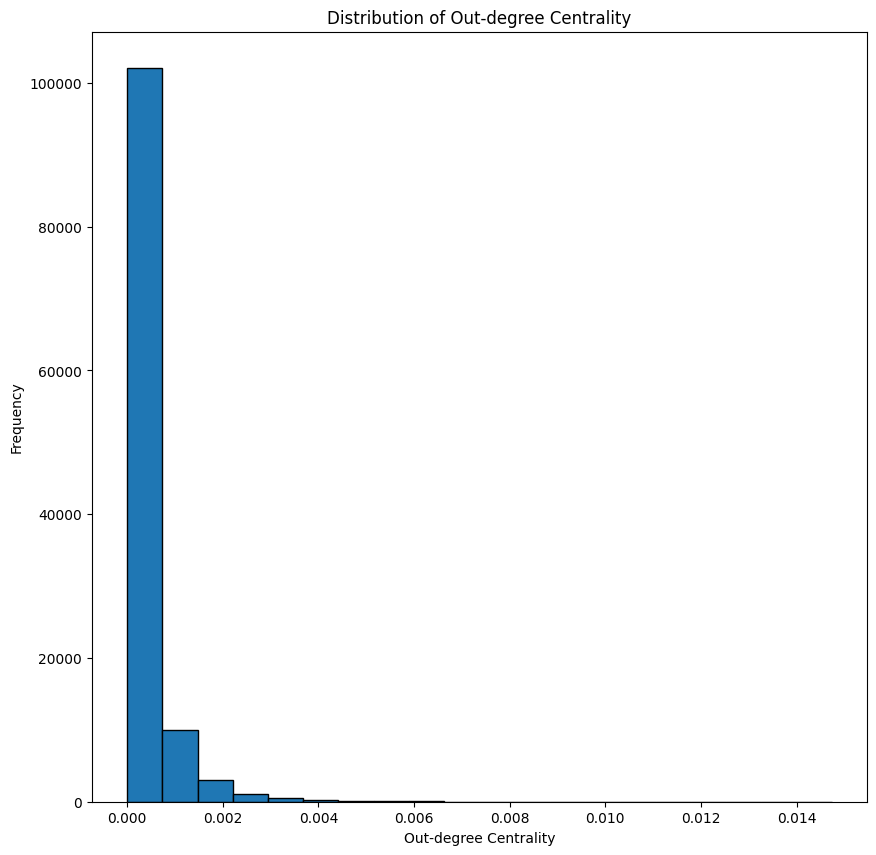

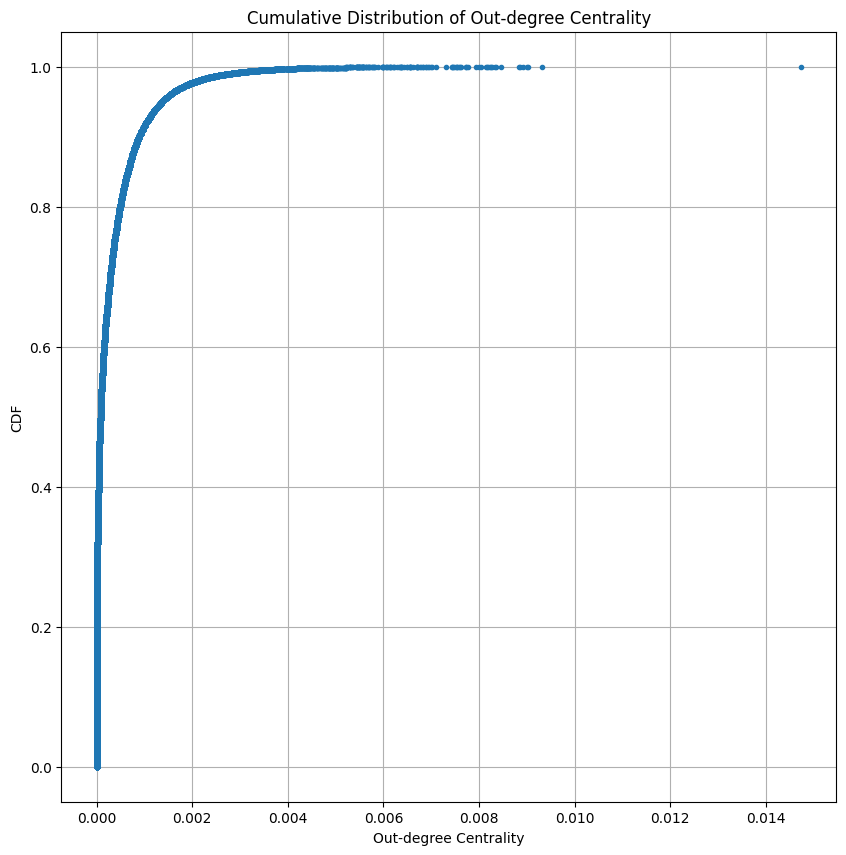

In [22]:
out_deg_cent = dict(sorted(nx.out_degree_centrality(gamesG).items(), key=lambda item: item[1], reverse=True))

values = list(out_deg_cent.values())

hist_plot(values, 'Distribution of Out-degree Centrality', 'Out-degree Centrality')

cdf_plot(values, 'Cumulative Distribution of Out-degree Centrality', 'Out-degree Centrality')

We can also compute the degree centrality overall, given by

$$
\text{Degree centrality of node } v = \frac{\text{in-degree of } v + \text{out-degree of } v}{N - 1}
$$

which is the sum of in and out-degree centrality.

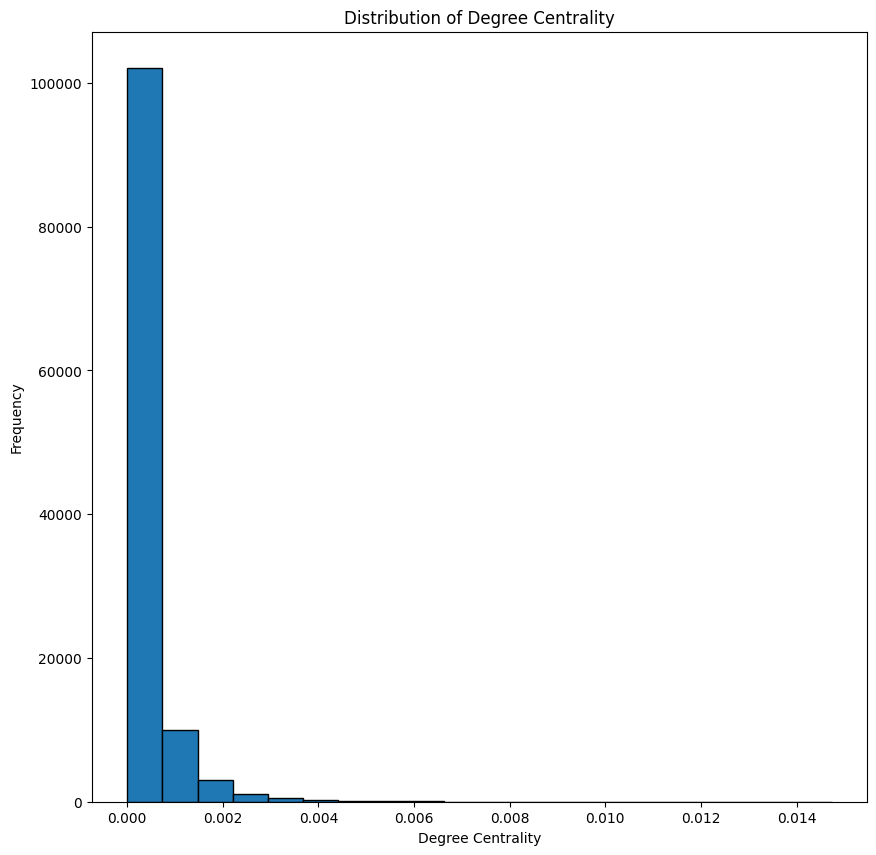

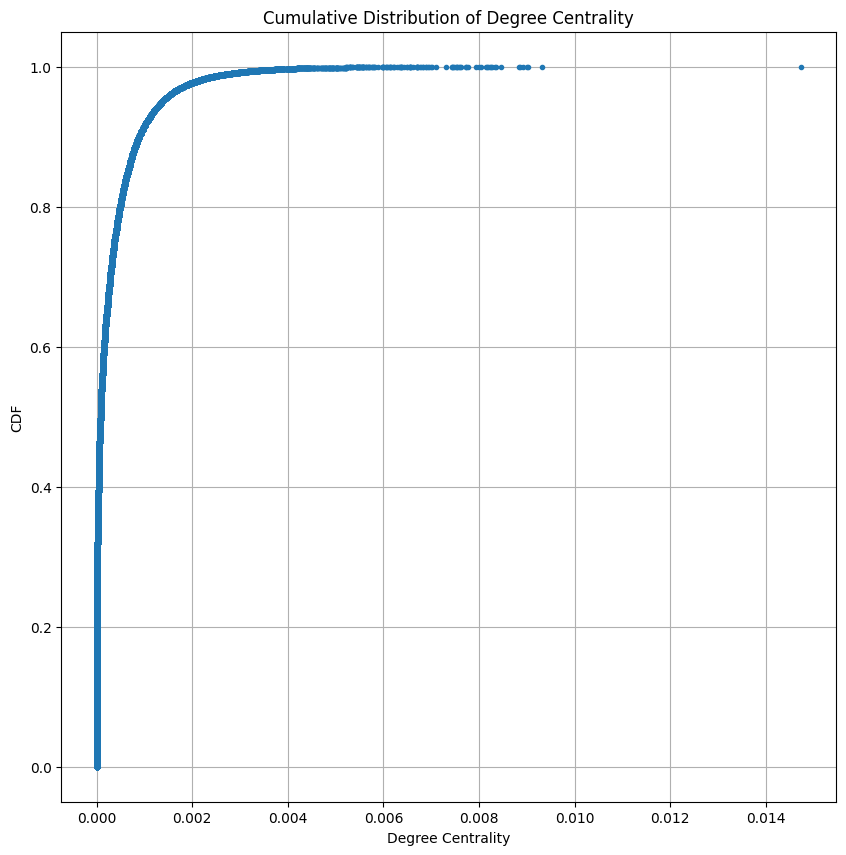

In [23]:
deg_cent = dict(sorted(nx.degree_centrality(gamesG).items(), key=lambda item: item[1], reverse=True))

hist_plot(values, 'Distribution of Degree Centrality', 'Degree Centrality')

cdf_plot(values, 'Cumulative Distribution of Degree Centrality', 'Degree Centrality')

Proximity

Proximity in the context of networks refers to the measure of how close or accessible nodes are to one another within the graph. It is typically used to understand the relationship between nodes in terms of distance or connectivity.Key concepts of proximity include shortest path distance, closeness centrality, betweenness centrality and neighborhood overlap.

Closeness Centrality

Closeness centrality measures how efficiently a node can reach all other nodes in a network. It is defined as the reciprocal of the average shortest path distance from a node to all other reachable nodes.
$$
C(v) = \frac{N-1}{\sum_{u \neq v} d(v, u)}
$$

Nodes with high closeness centrality have shorter paths to others, making them more central in terms of proximity.

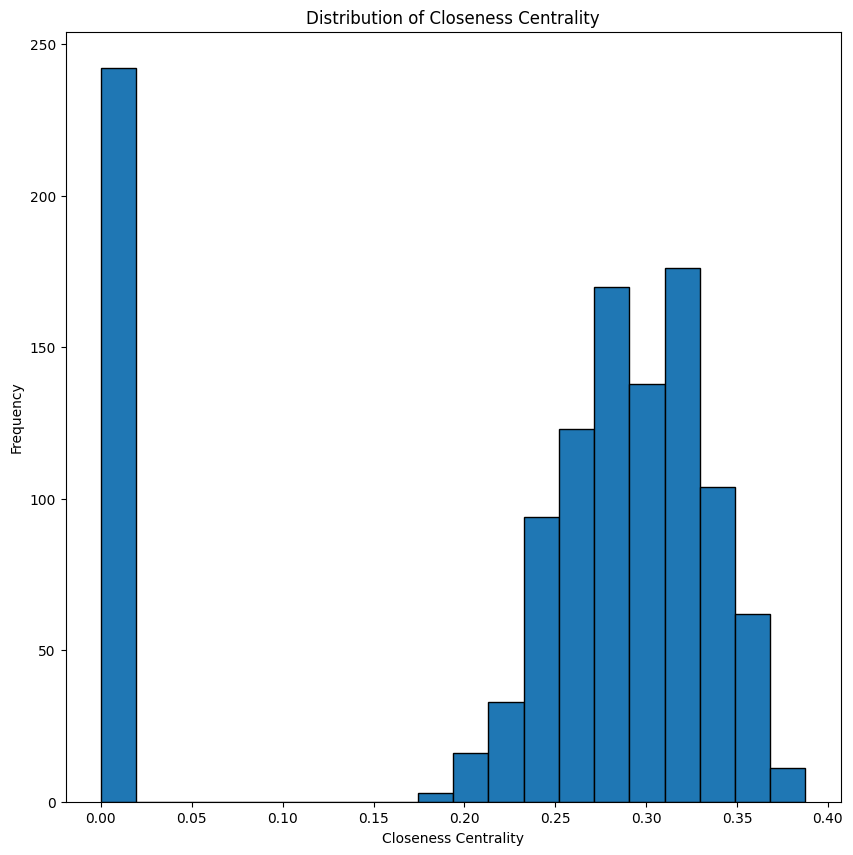

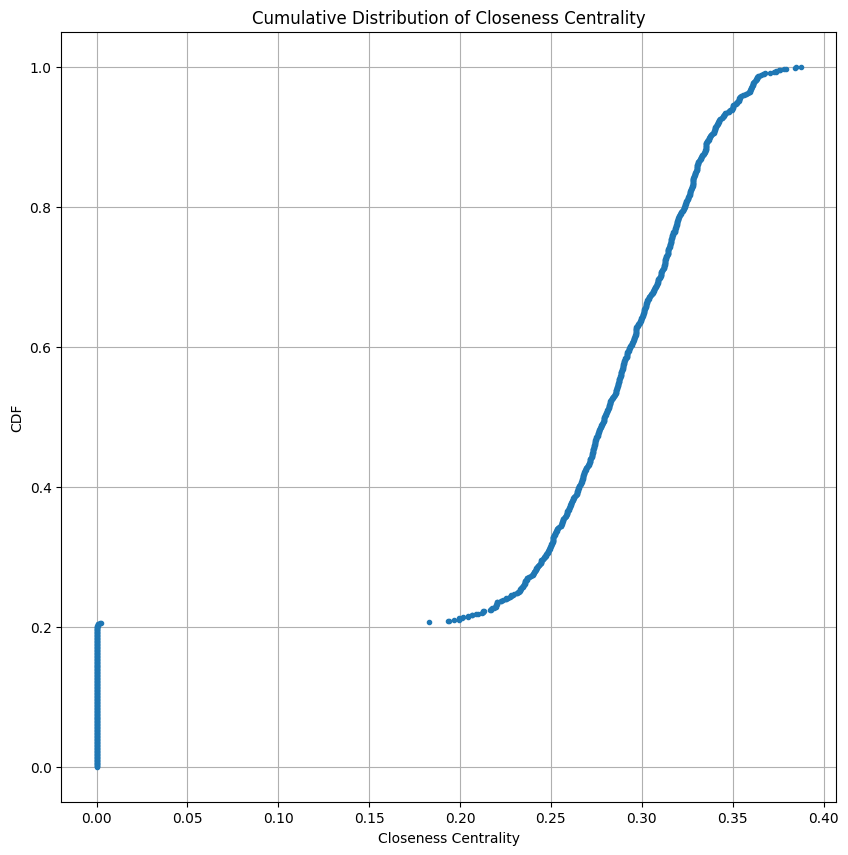

In [24]:
closeness_centrality = dict(sorted(nx.closeness_centrality(subgraph).items(), key=lambda item: item[1], reverse=True))

values = list(closeness_centrality.values())

hist_plot(values, 'Distribution of Closeness Centrality', 'Closeness Centrality')

cdf_plot(values, 'Cumulative Distribution of Closeness Centrality', 'Closeness Centrality')

Between Centrality

Betweenness centrality measures how often a node acts as a bridge along the shortest paths between other nodes in a network. It quantifies the importance of a node in facilitating communication or interaction across the graph.

$$
B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$

Nodes with high values are critical intermediaries, influencing flow and connectivity.


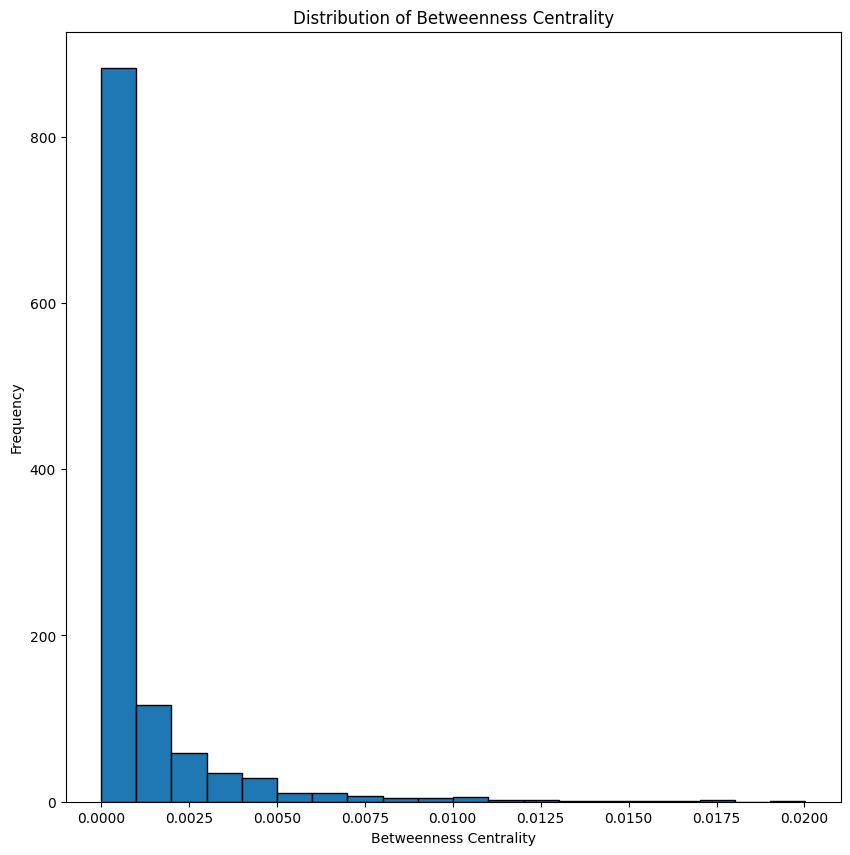

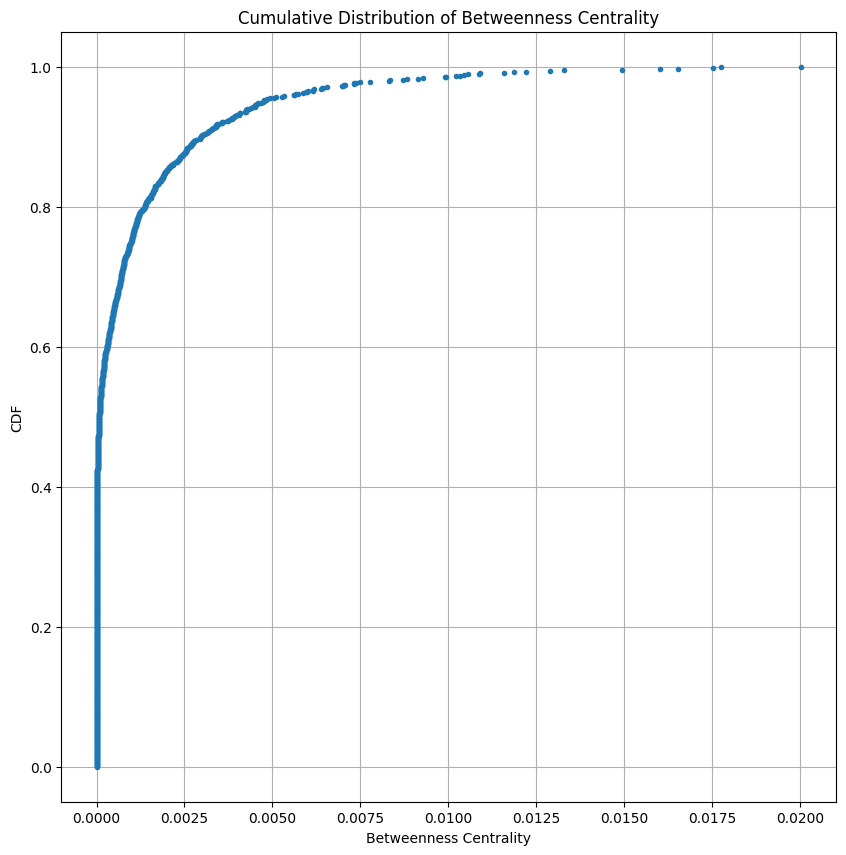

In [25]:
betwenness_centrality = dict(sorted(nx.betweenness_centrality(subgraph).items(), key=lambda item: item[1], reverse=True))

values = list(betwenness_centrality.values())

hist_plot(values, 'Distribution of Betweenness Centrality', 'Betweenness Centrality')

cdf_plot(values, 'Cumulative Distribution of Betweenness Centrality', 'Betweenness Centrality')

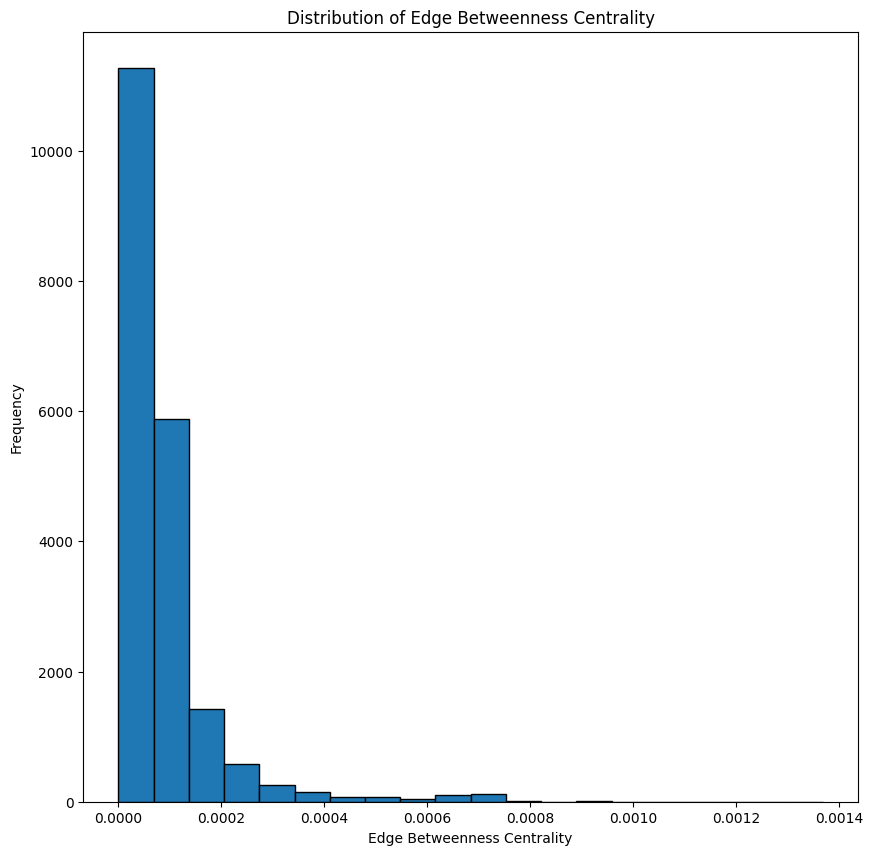

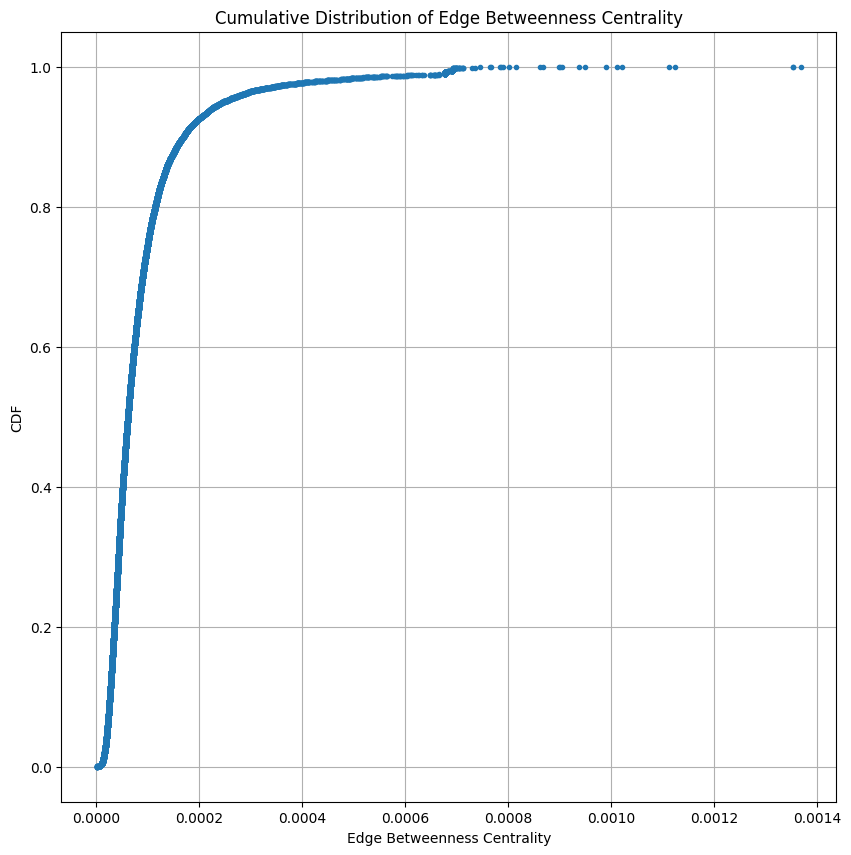

In [41]:
edge_betwenness_centrality = dict(sorted(nx.edge_betweenness_centrality(subgraph).items(), key=lambda item: item[1], reverse=True))

values = list(edge_betwenness_centrality.values())

hist_plot(values, 'Distribution of Edge Betweenness Centrality', 'Edge Betweenness Centrality')

cdf_plot(values, 'Cumulative Distribution of Edge Betweenness Centrality', 'Edge Betweenness Centrality')

# 4 - Communities (louvain + Girvan-newman) , clustering coefficient

Due to computational restraints, we outsourced all community-related applications to Gephi.

# 5 - Diameter, distances, shortest paths

Average Distance

The average distance between pairs of nodes represents the average of how many steps (or wins) are needed in a sequence to connect two players. In practical terms, this means that, on average, how many games from win to win are needed to ‘reach’ one player from another.

In [77]:
largest_scc = max(nx.strongly_connected_components(gamesG), key=len)  # Largest SCC
strongly_connected_subgraph = gamesG.subgraph(largest_scc).copy()  # Explicit copy for a standalone subgraph
largest_scc_1 = max(nx.strongly_connected_components(subgraph), key=len)  # Largest SCC
strongly_connected_subgraph_1 = subgraph.subgraph(largest_scc).copy()  # Explicit copy for a standalone subgraph

In [ ]:
def approximate_avg_shortest_path_length(graph, sample_size=5000):
    nodes = list(graph.nodes)
    total_distance = 0
    count = 0
    for _ in range(sample_size):
        # Randomly select two nodes
        u, v = random.sample(nodes, 2)
        try:
            total_distance += nx.shortest_path_length(graph, u, v)
            count += 1
        except nx.NetworkXNoPath:
            continue  # Skip if there's no path between nodes

    return total_distance / count if count > 0 else float('inf')

approx_avg_path_length = approximate_avg_shortest_path_length(strongly_connected_subgraph)
approx_avg_path_length_1 = approximate_avg_shortest_path_length(strongly_connected_subgraph_1)
print(f'Approximate average distance: {approx_avg_path_length}; Approximate average distance in the 1% subgraph: {approx_avg_path_length_1}')


Approximate average distance: 3.6862; Approximate average distance in the 1% subgraph: 3.6836


In a network of matches, a smaller average distance could indicate a more ‘connected’ network. This means that, on average, players are ‘close’ in terms of sequential wins. Therefore, they would potentially be within a winning circuit where the connections between players are more direct.


On the other hand, a greater average distance would indicate that there are more ‘jumps’ (or intermediate wins) needed to get from one player to another. This could suggest that the network is more ‘spread out’, i.e. less directly connected, possibly reflecting the presence of groups of players who play among themselves more often and have few connections with other groups.

Graph Diameter

The diameter is the greatest possible distance between two players within the largest strongly connected component of the network. In other words, it measures the longest winning path needed to connect two players who are still part of the same subgroup (or ‘cluster’) of the network.

In [ ]:
import random

def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes)
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_distance = 0

    for node in sampled_nodes:
        try:
            lengths = nx.single_source_shortest_path_length(graph, node)
            max_distance = max(max_distance, max(lengths.values()))
        except nx.NetworkXError:
            continue  # Skip if there are unreachable nodes
    return max_distance

# Use approximation on the strongly connected subgraph
approx_diameter = approximate_diameter(subgraph)
print(f'Approximate diameter of the largest SCC: {approx_diameter}')

Approximate diameter of the largest SCC: 9


In the context of your project, the diameter indicates the maximum distance for a ‘chain of wins’ to form between players in the same competition subgroup. If the diameter is small, this suggests that all the players within that component are relatively well connected in terms of wins (i.e. it is possible to connect everyone without too many intermediaries).


A very large diameter could indicate that there are players who are more peripheral, i.e. players who are ‘distant’ from the others in terms of sequential wins. This could mean a network with greater ‘depth’, where some players are ‘distant’ (in terms of wins) from others within the same competitive group.

Path Length


In [122]:
nodes_df[nodes_df.player == 'louisdevetter'].elo.iloc[0]

743.0

In [123]:
nodes_df.elo.sort_values()
#nodes_df[nodes_df.elo == 743.0]     # louisdevetter
#nodes_df[nodes_df.elo == 2954.0]     # BahadirOzen

nx.shortest_path(gamesG, 'louisdevetter', 'BahadirOzen')
for player in ['louisdevetter', 'Kupuk707', 'mahsa_iranian', 'puressence', 'BahadirOzen']:
    print(nodes_df[nodes_df.player == player].elo.iloc[0])

743.0
1186.0
1666.0
2269.0
2954.0


In a winning network, a lower average distance and a low diameter could indicate a more integrated competition community, where wins and losses happen in cycles or among a larger number of players. This could be characteristic of a more open network, where there aren't many ‘closed groups’ and everyone can, in theory, be reached quickly in terms of sequential victories.

On the other hand, a greater average distance and a high diameter would indicate that there are greater barriers to connectivity, perhaps representing subgroups or ‘clusters’ of players who rarely compete outside their immediate circle. This type of configuration suggests a network where win connections are more ‘fragmented’ and there are players who are more ‘isolated’ competitively, needing several wins to connect with other players in the network.